<a href="https://colab.research.google.com/github/Prasmaker/music-genre-classification/blob/main/Music_Genre_Classification_1D_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [1]:
!pip install memory_profiler

In [2]:
%matplotlib inline
from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import numpy as np

In [3]:
 %%capture
 !apt-get install libav-tools -y

In [4]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz

--2025-06-09 11:09:26--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c [following]
--2025-06-09 11:09:27--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2c5c8c0a33bc65996468809727.dl.dropboxusercontent.com/cd/0/inline/CrQzmpZwN1eve0ccNj0ew9Z5ckABTyeeyPgPhCufcvuvh0nP46NOYhHy8KkgSW66jj3sRhaVlwKY3jileKwmtPLvZGdczbjsO8jtRxi6wa-2lV4_NYwILd_2fB8UfDLModE/file# [following]
--2025-06-09 11:09:27--  https://uc2c5c8c0a33bc65996468809727.dl.dropboxusercontent.com/cd/0/inline/CrQzmpZwN1eve0ccNj

# New Section

Splitting Train and Test data properly and Then evaluating

In [17]:
import os
import tarfile

# Extracting the genres.tar.gz file
print("Extracting genres.tar.gz...")with tarfile.open('/content/genres.tar.gz', 'r:gz') as tar:
    tar.extractall('/content/')

print("Extraction complete!")

# Checking
print("\nContents of /content/ after extraction:")
for item in os.listdir('/content'):
    print(f" {item}")

# Genres folder
if os.path.exists('/content/genres'):
    print(f"\n /content/genres now exists!")
    print("Genre folders:")
    for item in os.listdir('/content/genres'):
        item_path = os.path.join('/content/genres', item)
        if os.path.isdir(item_path):
            file_count = len(os.listdir(item_path))
            print(f" {item}/ ({file_count} files)")

    # Check for audio files again
    from glob import glob
    audio_files = glob('/content/genres/**/*.au', recursive=True)
    print(f"\n Found {len(audio_files)} .au files")

    if audio_files:
        print("Sample files:")
        for file in audio_files[:3]:
            print(f"  {file}")

Extracting genres.tar.gz...
Extraction complete!

Contents of /content/ after extraction:
📁/📄 .config
📁/📄 train
📁/📄 genres
📁/📄 validation
📁/📄 test
📁/📄 genres.tar.gz
📁/📄 sample_data

✅ /content/genres now exists!
Genre folders:
📁 pop/ (100 files)
📁 hiphop/ (100 files)
📁 blues/ (100 files)
📁 reggae/ (100 files)
📁 classical/ (100 files)
📁 metal/ (100 files)
📁 country/ (100 files)
📁 jazz/ (100 files)
📁 rock/ (100 files)
📁 disco/ (100 files)

🎵 Found 1000 .au files
Sample files:
  /content/genres/pop/pop.00073.au
  /content/genres/pop/pop.00058.au
  /content/genres/pop/pop.00014.au


In [18]:
import os
import shutil
from sklearn.model_selection import train_test_split
from glob import glob
import pandas as pd

# Clean up existing directories (since we need to start fresh)
for dir_name in ['/content/train', '/content/validation', '/content/test']:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)

In [19]:
#New directories
os.makedirs('/content/train', exist_ok=True)
os.makedirs('/content/validation', exist_ok=True)

# Get all .au files
audio_files = glob('/content/genres/**/*.au', recursive=True)
print(f"Found {len(audio_files)} .au files")

Found 1000 .au files


In [20]:
#DataFrame for splitting
file_data = []
for audio_file in audio_files:
    genre = os.path.basename(os.path.dirname(audio_file))
    filename = os.path.basename(audio_file)
    file_data.append({
        'filepath': audio_file,
        'genre': genre,
        'filename': filename
    })

df = pd.DataFrame(file_data)
print(f"\nGenres: {df['genre'].unique()}")
print("Original distribution:")
print(df['genre'].value_counts())


Genres: ['pop' 'hiphop' 'blues' 'reggae' 'classical' 'metal' 'country' 'jazz'
 'rock' 'disco']
Original distribution:
genre
pop          100
hiphop       100
blues        100
reggae       100
classical    100
metal        100
country      100
jazz         100
rock         100
disco        100
Name: count, dtype: int64


In [21]:
df

,filepath,genre,filename
0,/content/genres/pop/pop.00073.au,pop,pop.00073.au
1,/content/genres/pop/pop.00058.au,pop,pop.00058.au
2,/content/genres/pop/pop.00014.au,pop,pop.00014.au
3,/content/genres/pop/pop.00038.au,pop,pop.00038.au
4,/content/genres/pop/pop.00061.au,pop,pop.00061.au
...,...,...,...
995,/content/genres/disco/disco.00082.au,disco,disco.00082.au
996,/content/genres/disco/disco.00075.au,disco,disco.00075.au
997,/content/genres/disco/disco.00091.au,disco,disco.00091.au
998,/content/genres/disco/disco.00068.au,disco,disco.00068.au


In [22]:
train_files, val_files = train_test_split(
    df,
    test_size=0.2,  # 80% train, 20% validation
    stratify=df['genre'],  # Ensure equal genre distribution
    random_state=42
)

print(f"\nAfter split:")
print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print("\nTraining genre distribution:")
print(train_files['genre'].value_counts())
print("\nValidation genre distribution:")
print(val_files['genre'].value_counts())


After split:
Training files: 800
Validation files: 200

Training genre distribution:
genre
jazz         80
country      80
rock         80
hiphop       80
pop          80
reggae       80
metal        80
blues        80
classical    80
disco        80
Name: count, dtype: int64

Validation genre distribution:
genre
classical    20
blues        20
metal        20
jazz         20
country      20
rock         20
hiphop       20
reggae       20
disco        20
pop          20
Name: count, dtype: int64


In [23]:
#Creating spectrograms
import librosa
import matplotlib.pyplot as plt
import numpy as np

def create_spectrogram(filename, name, save_dir):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    save_path = os.path.join(save_dir, name + '.jpg')
    plt.savefig(save_path, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename, name, clip, sample_rate, fig, ax, S

print("Creating spectrograms for training set...")
for i, row in train_files.iterrows():
    audio_file = row['filepath']
    genre = row['genre']
    filename = row['filename'].replace('.au', '')
    spectrogram_name = f"{genre}_{filename}_{i}"

    try:
        create_spectrogram(audio_file, spectrogram_name, '/content/train')
        if i % 100 == 0:
            print(f"Processed {i} training files...")
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

print("Creating spectrograms for validation set...")
for i, row in val_files.iterrows():
    audio_file = row['filepath']
    genre = row['genre']
    filename = row['filename'].replace('.au', '')
    spectrogram_name = f"{genre}_{filename}_{i}"

    try:
        create_spectrogram(audio_file, spectrogram_name, '/content/validation')
        if i % 50 == 0:
            print(f"Processed validation file at index {i}...")
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

print("Done creating spectrograms!")

Creating spectrograms for training set...
Processed 200 training files...
Processed 700 training files...
Processed 900 training files...
Processed 500 training files...
Processed 400 training files...
Processed 800 training files...
Processed 100 training files...
Processed 300 training files...
Creating spectrograms for validation set...
Processed validation file at index 600...
Processed validation file at index 350...
Processed validation file at index 950...
Processed validation file at index 0...
Done creating spectrograms!


In [24]:
train_spectrograms = glob('/content/train/*.jpg')
val_spectrograms = glob('/content/validation/*.jpg')
print(f"\nCreated {len(train_spectrograms)} training spectrograms")
print(f"Created {len(val_spectrograms)} validation spectrograms")


Created 800 training spectrograms
Created 200 validation spectrograms


In [25]:
import pandas as pd
from glob import glob
import os

#Labels for training set
train_spectrograms = glob('/content/train/*.jpg')
train_labels_data = []
for file_path in train_spectrograms:
    filename = os.path.basename(file_path)
    genre = filename.split('_')[0]
    train_labels_data.append({
        'filename': filename,
        'genre': genre,
        'filepath': file_path
    })

train_labels = pd.DataFrame(train_labels_data)
print(f"Training labels created: {len(train_labels)}")
print(f"Training genres: {train_labels['genre'].unique()}")
print("Training genre distribution:")
print(train_labels['genre'].value_counts())



Training labels created: 800
Training genres: ['metal' 'hiphop' 'pop' 'jazz' 'country' 'rock' 'disco' 'classical'
 'reggae' 'blues']
Training genre distribution:
genre
metal        80
hiphop       80
pop          80
jazz         80
country      80
rock         80
disco        80
classical    80
reggae       80
blues        80
Name: count, dtype: int64


In [26]:
# Labels for validation set
val_spectrograms = glob('/content/validation/*.jpg')
val_labels_data = []
for file_path in val_spectrograms:
    filename = os.path.basename(file_path)
    genre = filename.split('_')[0]
    val_labels_data.append({
        'filename': filename,
        'genre': genre,
        'filepath': file_path
    })

val_labels = pd.DataFrame(val_labels_data)
print(f"\nValidation labels created: {len(val_labels)}")
print(f"Validation genres: {val_labels['genre'].unique()}")
print("Validation genre distribution:")
print(val_labels['genre'].value_counts())


Validation labels created: 200
Validation genres: ['pop' 'classical' 'jazz' 'reggae' 'rock' 'metal' 'blues' 'hiphop'
 'country' 'disco']
Validation genre distribution:
genre
pop          20
classical    20
jazz         20
reggae       20
rock         20
metal        20
blues        20
hiphop       20
country      20
disco        20
Name: count, dtype: int64


In [27]:
classes = list(train_labels['genre'].value_counts().index)
print(f"\nClasses: {classes}")


Classes: ['metal', 'hiphop', 'pop', 'jazz', 'country', 'rock', 'disco', 'classical', 'reggae', 'blues']


In [28]:
import shutil

# Genre folders for training
for genre in classes:
    os.makedirs(f'/content/train/{genre}', exist_ok=True)

In [29]:
# Genre folders for validation
for genre in classes:
    os.makedirs(f'/content/validation/{genre}', exist_ok=True)

In [30]:
print("Created genre folders")

Created genre folders


In [31]:
# Moving the spectrograms to appropriate folders
print("Organizing training spectrograms...")
for _, row in train_labels.iterrows():
    old_path = row['filepath']
    genre = row['genre']
    filename = row['filename']
    new_path = f'/content/train/{genre}/{filename}'

    try:
        shutil.move(old_path, new_path)
    except Exception as e:
        print(f"Error moving {filename}: {e}")

Organizing training spectrograms...


In [32]:


for _, row in val_labels.iterrows():
    old_path = row['filepath']
    genre = row['genre']
    filename = row['filename']
    new_path = f'/content/validation/{genre}/{filename}'

    try:
        shutil.move(old_path, new_path)
    except Exception as e:
        print(f"Error moving {filename}: {e}")

print("Organization complete!")

Organizing validation spectrograms...
Organization complete!


In [33]:
# Verify
print("\nTraining folder structure:")
for genre in classes:
    count = len(os.listdir(f'/content/train/{genre}'))
    print(f"  {genre}: {count} files")

print("\nValidation folder structure:")
for genre in classes:
    count = len(os.listdir(f'/content/validation/{genre}'))
    print(f"  {genre}: {count} files")


Training folder structure:
  metal: 80 files
  hiphop: 80 files
  pop: 80 files
  jazz: 80 files
  country: 80 files
  rock: 80 files
  disco: 80 files
  classical: 80 files
  reggae: 80 files
  blues: 80 files

Validation folder structure:
  metal: 20 files
  hiphop: 20 files
  pop: 20 files
  jazz: 20 files
  country: 20 files
  rock: 20 files
  disco: 20 files
  classical: 20 files
  reggae: 20 files
  blues: 20 files


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
WIDTH = 64
HEIGHT = 64
BATCH_SIZE = 32
TRAIN_DIR = '/content/train'
VALIDATION_DIR = '/content/validation'

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Check the setup
#print(f"Training samples: {train_generator.samples}")
#print(f"Validation samples: {validation_generator.samples}")
#print(f"Number of classes: {train_generator.num_classes}")
#print(f"Class indices: {train_generator.class_indices}")

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Training samples: 800
Validation samples: 200
Number of classes: 10
Class indices: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Creating The 2D CNN Model

In [35]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.compile(optimizers.RMSprop(learning_rate=0.0005, decay=1e-6),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,679,626 (10.22 MB)

 Trainable params: 2,679,626 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=150
)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5467 - loss: 1.2579 - val_accuracy: 0.5677 - val_loss: 1.2290
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5602 - loss: 1.1589 - val_accuracy: 0.5365 - val_loss: 1.2682
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5620 - loss: 1.2101 - val_accuracy: 0.5625 - val_loss: 1.3295
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5449 - loss: 1.1909 - val_accuracy: 0.6146 - val_loss: 1.1161
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5740 - loss: 1.2025 - val_accuracy: 0.5729 - val_loss: 1.2419
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5765 - loss: 1.1816 - val_accuracy: 0.6562 - val_loss: 1.0742
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5833 - loss: 1.1604 - val_accuracy: 0.6094 - val_loss: 1.1668
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6048 - loss: 1.1504 - val_accuracy: 0.5365 - v

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
print("Generating predictions...")
validation_generator.reset()  # Reset generator to start from beginning
predictions = model.predict(validation_generator, steps=STEP_SIZE_VALID)
predicted_classes = np.argmax(predictions, axis=1)

Generating predictions...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step


In [46]:
# 2. Get true labels
true_classes = validation_generator.classes[:len(predicted_classes)]
class_labels = list(validation_generator.class_indices.keys())

In [47]:
print(f"Number of predictions: {len(predicted_classes)}")
print(f"Number of true labels: {len(true_classes)}")

Number of predictions: 192
Number of true labels: 192


In [48]:
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Test Accuracy: 0.5260 (52.60%)


In [49]:
# 4. Detailed classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       blues       0.44      0.40      0.42        20
   classical       0.91      1.00      0.95        20
     country       0.37      0.90      0.52        20
       disco       0.42      0.70      0.53        20
      hiphop       1.00      0.10      0.18        20
        jazz       0.75      0.60      0.67        20
       metal       1.00      0.20      0.33        20
         pop       0.85      0.55      0.67        20
      reggae       0.62      0.50      0.56        20
        rock       0.11      0.17      0.13        12

    accuracy                           0.53       192
   macro avg       0.65      0.51      0.50       192
weighted avg       0.67      0.53      0.51       192



<Figure size 1000x800 with 0 Axes>

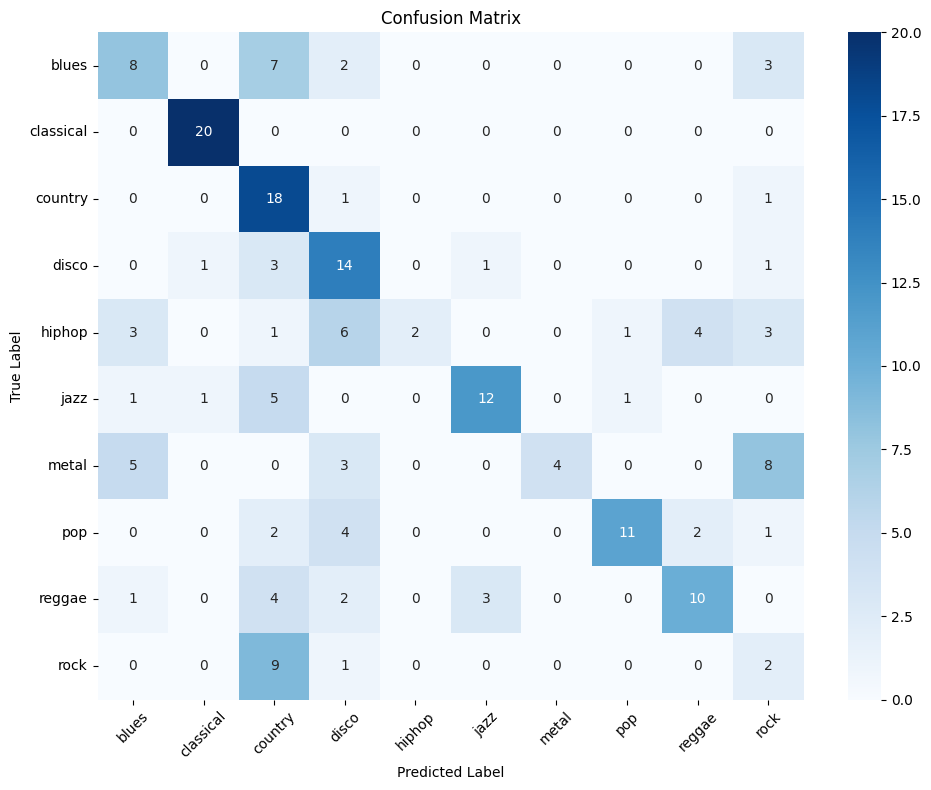

In [51]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [52]:
print("\nPer-class Accuracy:")
for i, genre in enumerate(class_labels):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{genre}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")


Per-class Accuracy:
blues: 0.4000 (40.00%)
classical: 1.0000 (100.00%)
country: 0.9000 (90.00%)
disco: 0.7000 (70.00%)
hiphop: 0.1000 (10.00%)
jazz: 0.6000 (60.00%)
metal: 0.2000 (20.00%)
pop: 0.5500 (55.00%)
reggae: 0.5000 (50.00%)
rock: 0.1667 (16.67%)
